<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_logistic_regression_2_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Life on TensorFlow
A hueristic implementation of the Game of Life algorythm to create a dataset to train a model that mimics the Life algorythm.
The convolutional network is able to learn a single step of the game of life rules from fewer then 40 examples. 

In [37]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
    '\n\nThis error most likely means that this notebook is not '
    'configured to use a GPU.  Change this in Notebook Settings via the '
    'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


In [0]:
FEATURES_SHAPE = [1024,1024,1]
LABELS_SHAPE = [1024,1024,1]
SET_SIZE = 200

def random_uniform_grid(shape=FEATURES_SHAPE):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32))

In [0]:
def convolve_for_density_map(X):
  life_density_kernal = tf.constant([[[[1]],[[1]],[[1]]],
                                   [[[1]],[[10]],[[1]]],
                                   [[[1]],[[1]],[[1]]]],dtype=tf.float32)
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  density_map = tf.nn.conv2d(X_reshaped,life_density_kernal,[1,1,1,1],"SAME")
  density_map = tf.reshape(density_map,X.shape)
  return tf.round(density_map)

def will_be_alive(density_map):
  is_three = tf.equal(density_map,3.0)
  is_twelve = tf.equal(density_map,12.0)
  is_thirteen = tf.equal(density_map,13.0)
  any_true = is_three | is_twelve | is_thirteen
  return tf.cast(any_true,dtype=tf.float32)

def step(X):
  density_map = convolve_for_density_map(X)
  #print(density_map)
  return will_be_alive(density_map)

In [0]:
def get_data_examples(size = SET_SIZE):
  for i in range(size):
    X = random_uniform_grid()
    Y1 = step(X)
    Y2 = step(Y1)
    yield X,Y2

def get_dataset():
  return tf.data.Dataset.from_generator(get_data_examples,(tf.float32,tf.float32),(tf.TensorShape(FEATURES_SHAPE),tf.TensorShape(LABELS_SHAPE)))
  
X_COMMON = get_dataset()

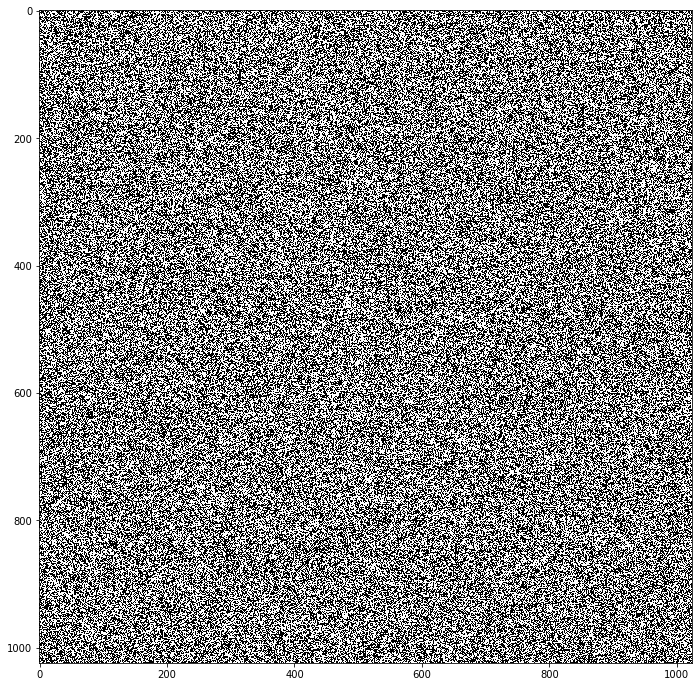

In [41]:
for element in X_COMMON: 
  e = element
  break
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[0]),cmap='Greys',origin='upper',interpolation='nearest')

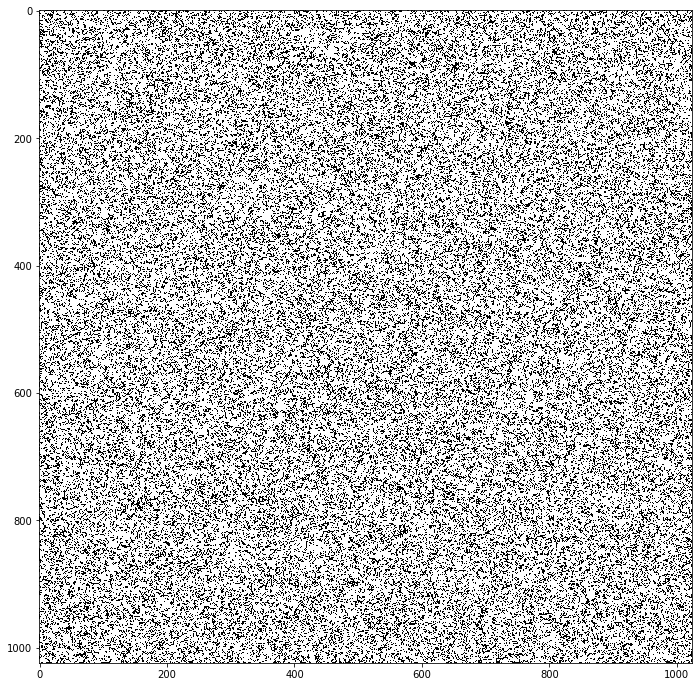

In [42]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[1]),cmap='Greys',origin='upper',interpolation='nearest')

In [0]:
model1 = models.Sequential()
model1.add(layers.Conv2D(8, (5, 5), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model1.add(layers.Dense(8, activation='relu'))
model1.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model1.add(layers.Dense(8, activation='relu'))
model1.add(layers.Dense(8, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))
model1.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['accuracy'])

In [44]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1024, 1024, 8)     208       
_________________________________________________________________
dense_8 (Dense)              (None, 1024, 1024, 8)     72        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1024, 1024, 8)     584       
_________________________________________________________________
dense_9 (Dense)              (None, 1024, 1024, 8)     72        
_________________________________________________________________
dense_10 (Dense)             (None, 1024, 1024, 8)     72        
_________________________________________________________________
dense_11 (Dense)             (None, 1024, 1024, 1)     9         
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
____________________________________________________

In [45]:
X_COMMON1 = X_COMMON.batch(2)
%time model1.fit(X_COMMON1,epochs=12)

Epoch 1/12
100/100 [==============================] - 19s 188ms/step - loss: 0.1771 - accuracy: 0.7464
Epoch 2/12
100/100 [==============================] - 19s 188ms/step - loss: 0.1450 - accuracy: 0.7725
Epoch 3/12
100/100 [==============================] - 19s 188ms/step - loss: 0.1017 - accuracy: 0.8520
Epoch 4/12
100/100 [==============================] - 19s 187ms/step - loss: 0.0601 - accuracy: 0.9226
Epoch 5/12
100/100 [==============================] - 19s 187ms/step - loss: 0.0410 - accuracy: 0.9469
Epoch 6/12
100/100 [==============================] - 19s 186ms/step - loss: 0.0536 - accuracy: 0.9264
Epoch 7/12
100/100 [==============================] - 19s 186ms/step - loss: 0.0265 - accuracy: 0.9626
Epoch 8/12
100/100 [==============================] - 19s 187ms/step - loss: 0.0195 - accuracy: 0.9747
Epoch 9/12
100/100 [==============================] - 19s 187ms/step - loss: 0.0054 - accuracy: 0.9952
Epoch 10/12
100/100 [==============================] - 19s 186ms/step - l

In [0]:
testset = get_dataset()

In [47]:
testset1 = testset.batch(10)
model1.evaluate(testset1)

20/20 [==============================] - 3s 170ms/step - loss: 4.2830e-04 - accuracy: 1.0000


[0.0004283039888832718, 0.9999664425849915]

In [0]:
%%script false --no-raise-error
model2 = models.Sequential()
model2.add(layers.Conv2D(16, (5, 5), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1))
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['accuracy'])

In [0]:
%%script false --no-raise-error
model2.summary()

In [0]:
%%script false --no-raise-error
X_COMMON2 = X_COMMON.batch(2)
%time model2.fit(X_COMMON2,epochs=10)

In [0]:
%%script false --no-raise-error
testset2 = testset.batch(10)
model2.evaluate(testset2)

In [0]:
%%script false --no-raise-error
model3 = models.Sequential()
model3.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(1))
model3.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['accuracy'])

In [0]:
%%script false --no-raise-error
X_COMMON3 = X_COMMON.batch(2)
%time model3.fit(X_COMMON3,epochs=10)

In [0]:
%%script false --no-raise-error
testset3 = testset.batch(10)
model3.evaluate(testset3)